#  Principal Component Analysis

PCA is unsupervised learning, fundamentally a dimensionality reduction algorithm.
It is a transformation of the data and tries to find out what features explain the most variance in the data. PCA is widely used as a dimensional reduction approach for preprocessing big data, and it can thus speed up machine learning algorithms. 

## Basics

* Each variable/feature of the data are **centered around the origin by substracting the mean**.

* PCA is a linear transformation that transforms the data to a new coordinate system such that the greatest variance by some scalar projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

* **Principal components** are unit directions (basis) of the new coordinate system. Their computations involve singular value decomposition (SVD). 

* The data representation are transformed under the new coordinate system.

* The **explained variance** for a principal component is the variance of data along the corresponding coordinate/direction.

* Less important principal components/coordinates (with small explained variance) are discarded.


<img src='PCA.png' width = 700>

We begin with the standard imports:

In [9]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Its behavior is easiest to visualize by looking at a two-dimensional dataset.
Consider the following 200 points:

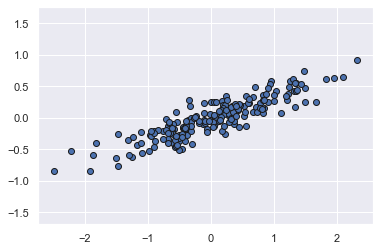

In [10]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1], edgecolor = 'k')
plt.axis('equal');

It is clear that there is a nearly linear relationship between the x and y variables. In principal component analysis, this relationship is quantified by finding a list of the principal components in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [12]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [13]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [14]:
print(pca.explained_variance_)

[0.7625315 0.0184779]


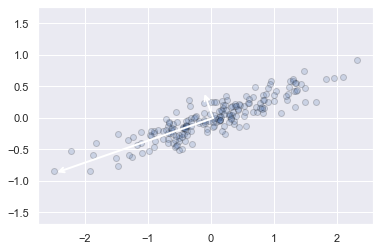

In [15]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, edgecolor = 'k')
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

These vectors represent the **principal axes** of the data, and the length of the vector is an indication of how "important" that axis is in describing the distribution of the data—more precisely, it is a measure of the variance of the data when projected onto that axis.
The projection of each data point onto the principal axes are the "principal components" of the data.

### PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

Here is an example of using PCA as a dimensionality reduction transform:

In [17]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data and plot it along with the original data:

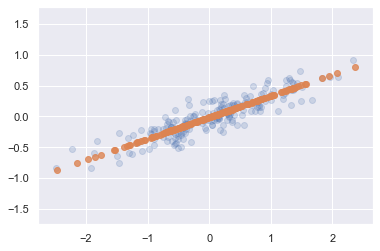

In [18]:
X_new = pca.inverse_transform(X_pca) # transform back into the original system
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

The light points are the original data, while the dark points are the projected version.
This makes clear what a PCA dimensionality reduction means: the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.
The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### PCA for visualization: Hand-written digits

The usefulness of the dimensionality reduction may not be entirely apparent in only two dimensions, but becomes much more clear when looking at high-dimensional data.

We start by loading the data:

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

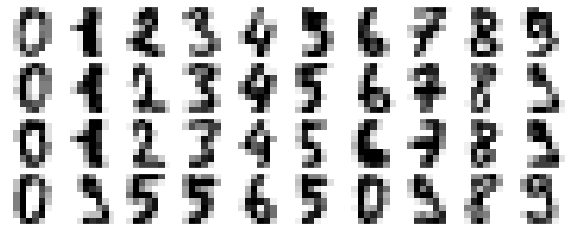

In [20]:
fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                        subplot_kw={'xticks':[], 'yticks':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.data[i].reshape(8, 8),
                cmap='binary', clim=(0, 16))

Recall that the data consists of 8×8 pixel images, meaning that they are 64-dimensional.
To gain some intuition into the relationships between these points, we can use PCA to project them to a more manageable number of dimensions, say two:

In [21]:
pca = PCA(n_components = 2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


We can now plot the first two principal components of each point to learn about the data:

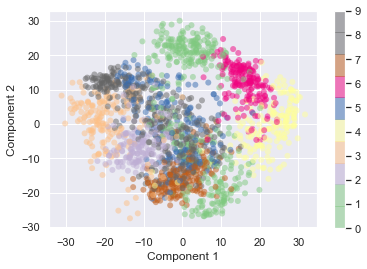

In [22]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('Accent', 10))
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar();

Recall what these components mean: the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.
Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### What do the components mean?

We can go a bit further here, and begin to ask what the reduced dimensions *mean*.
This meaning can be understood in terms of combinations of basis vectors.
For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector $x$:

$$
x = [x_1, x_2, x_3 \cdots x_{64}]
$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$$
{\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors.
For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image: we've thrown out nearly 90% of the pixels.

<img src='digits-pixel-components.png'>

The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.
Using only eight of the pixel-basis components, we can only construct a small portion of the 64-pixel image.
Were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
{\rm image}(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots
$$

PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.
This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

<img src='digits-pca-components.png'>

Unlike the pixel basis, the PCA basis allows us to recover the salient features of the input image with just a mean plus eight components!
The amount of each pixel in each component is the corollary of the orientation of the vector in our two-dimensional example.
This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### Choosing the number of components

A vital part of using PCA in practice is the ability to estimate how many components are needed to describe the data.
This can be determined by looking at the cumulative **explained variance ratio** as a function of the number of components:

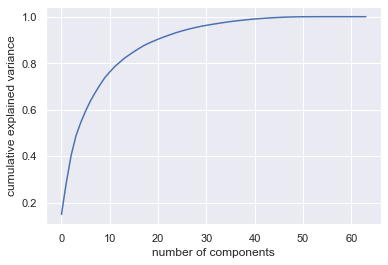

In [23]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first $N$ components.
For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around 50 components to describe close to 100% of the variance.

Here we see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## Eigenfaces

Earlier we explored an example of using a PCA projection as a feature selector for facial recognition with a support vector machine.
Here we will take a look back and explore a bit more of what went into that.
Recall that we were using the Labeled Faces in the Wild dataset made available through Scikit-Learn:

In [24]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Let's take a look at the principal axes that span this dataset. Because this is a large dataset, we will use randomized PCA — it uses a randomized SVD method to approximate the first $N$ principal components much more quickly than the standard ``PCA`` estimator, and thus is very useful for high-dimensional data (a dimensionality of nearly 3,000).

We look at the first 150 components:

In [27]:
pca = PCA(150, svd_solver = 'randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='randomized', tol=0.0, whiten=False)

In this case, it can be interesting to visualize the images associated with the first several principal components (these components are technically known as "eigenvectors,"
so these types of images are often called "eigenfaces").
As you can see in this figure, they are as creepy as they sound:

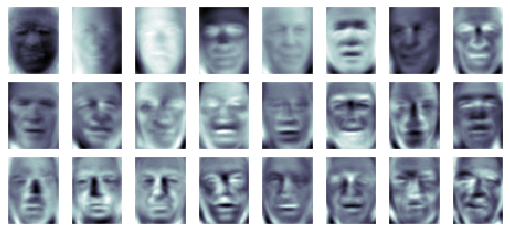

In [28]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

The results are very interesting, and give us insight into how the images vary: for example, the first few eigenfaces (from the top left) seem to be associated with the angle of lighting on the face, and later principal vectors seem to be picking out certain features, such as eyes, noses, and lips.
Let's take a look at the cumulative variance of these components to see how much of the data information the projection is preserving:

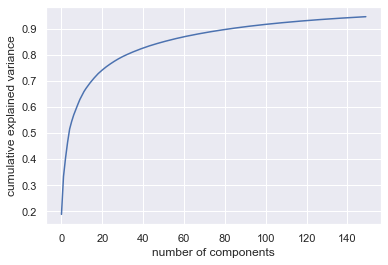

In [29]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

We see that these 150 components account for just over 90% of the variance.
That would lead us to believe that using these 150 components, we would recover most of the essential characteristics of the data.
To make this more concrete, we can compare the input images with the images reconstructed from these 150 components:

In [30]:
# Compute the components and projected faces
pca = PCA(150, svd_solver = 'randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

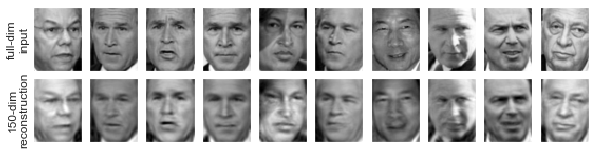

In [32]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

The top row here shows the input images, while the bottom row shows the reconstruction of the images from just 150 of the ~3,000 initial features.
Although it reduces the dimensionality of the data by nearly a factor of 20, the projected images contain enough information that we might, by eye, recognize the individuals in the image.
What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

## The Cancer Dataset

569 labelled samples of 30 dimensions/features, to predict cancer or not 

In [33]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
# it's a dictionary

In [34]:
cancer.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [35]:
cancer['DESCR']

'.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry \n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        largest values) of these features were computed for each image,\n        resulting in 30 features.  For instance,

In [36]:
# feature dataframe
df = pd.DataFrame(cancer['data'],columns=cancer['feature_names'])
#(['DESCR', 'data', 'feature_names', 'target_names', 'target'])
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## PCA Visualization

We can use PCA to find the first two principal components, and visualize the data in this new, two-dimensional space, with a single scatter-plot. We first standardize the data so that each feature has a single unit variance.

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [39]:
# scaling data by calling transform(), return a numpy array
scaled_data = scaler.transform(df)
type(scaled_data)

numpy.ndarray

In [40]:
scaled_df = pd.DataFrame(scaled_data,columns=cancer['feature_names'])
scaled_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


#### Perform PCA

In [41]:
from sklearn.decomposition import PCA
# specify how many components/dimension to keep when creating the PCA object.
pca = PCA(n_components=2)
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

#### Interpreting the components
The components correspond to (two) most informative linear combinations of the original features. They are stored as an attribute of the fitted PCA object. The attribute ``pca.components_`` is a 2-by-30 numpy matrix array, each row represents a principal component, and each column relates back to the original features. This matrix can be viewed as a projection matrix which transforms the original 30-D data points into 2-D ones by left-multiplication.

In [42]:
pca.components_

array([[ 0.21890244,  0.10372458,  0.22753729,  0.22099499,  0.14258969,
         0.23928535,  0.25840048,  0.26085376,  0.13816696,  0.06436335,
         0.20597878,  0.01742803,  0.21132592,  0.20286964,  0.01453145,
         0.17039345,  0.15358979,  0.1834174 ,  0.04249842,  0.10256832,
         0.22799663,  0.10446933,  0.23663968,  0.22487053,  0.12795256,
         0.21009588,  0.22876753,  0.25088597,  0.12290456,  0.13178394],
       [-0.23385713, -0.05970609, -0.21518136, -0.23107671,  0.18611302,
         0.15189161,  0.06016536, -0.0347675 ,  0.19034877,  0.36657547,
        -0.10555215,  0.08997968, -0.08945723, -0.15229263,  0.20443045,
         0.2327159 ,  0.19720728,  0.13032156,  0.183848  ,  0.28009203,
        -0.21986638, -0.0454673 , -0.19987843, -0.21935186,  0.17230435,
         0.14359317,  0.09796411, -0.00825724,  0.14188335,  0.27533947]])

Now we can transform this data to its first 2 principal components. This basically amounts to projecting 4-D data points onto a 2-D plane spanned by the pricipal components. Apply the rotation and dimensionality reduction by calling transform().

In [43]:
pca_data = pca.transform(scaled_data)

In [44]:
scaled_data.shape

(569, 30)

In [45]:
pca_data.shape

(569, 2)

In [46]:
# show the PCA data as a dataframe
pca_df = pd.DataFrame(pca_data,columns=['component 1', 'component 2'])
pca_df.head()

,component 1,component 2
0,9.192837,1.948583
1,2.387802,-3.768172
2,5.733896,-1.075174
3,7.122953,10.275589
4,3.935302,-1.948072


**Plot out these two dimensions**

Text(0, 0.5, 'second principal component')

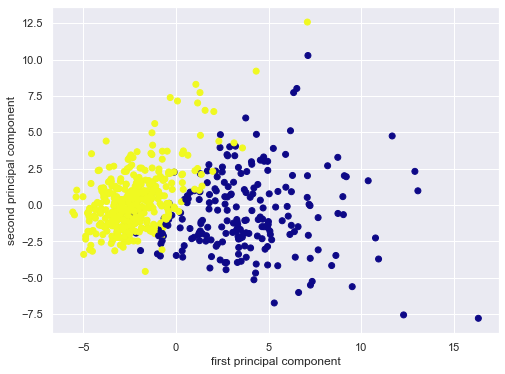

In [47]:
plt.figure(figsize=(8,6))
plt.scatter(pca_data[:,0],pca_data[:,1],c=cancer['target'],cmap='plasma')
plt.xlabel('first principal component')
plt.ylabel('second principal component')

## Machine Learning with Dimensional Reduction

### Logistic regression on orginal (standardized) cancer data

In [48]:
from sklearn.model_selection import train_test_split
# 15% of the samples retained for testing
X_train, X_test, y_train, y_test = train_test_split(scaled_data, 
                                                    cancer['target'], test_size=0.15, 
                                                    random_state=101)

In [49]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
predictions = logmodel.predict(X_test)

/Users/Penghang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


#### Evaluation

In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        33
           1       0.98      1.00      0.99        53

    accuracy                           0.99        86
   macro avg       0.99      0.98      0.99        86
weighted avg       0.99      0.99      0.99        86



### Logistic regression on 2-D PCA data

In [51]:
X_pca_train, X_pca_test, y_train, y_test = train_test_split(pca_df, 
                                                    cancer['target'], test_size=0.15, 
                                                    random_state=101)
logmodel.fit(X_pca_train,y_train)
predictions_pca = logmodel.predict(X_pca_test)

/Users/Penghang/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [52]:
print(classification_report(y_test,predictions_pca))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.98      0.98      0.98        53

    accuracy                           0.98        86
   macro avg       0.98      0.98      0.98        86
weighted avg       0.98      0.98      0.98        86



**We see only little degration in accuracy when reducing the data dimension from 30 to 2 via PCA!**